## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [8]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp_wL1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_wL2(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_wL1_L2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# hyparameters
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [9]:
results_L1 = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_wL1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results_L1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 158us/step - loss: 2.4626 - accuracy: 0.0967 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 159us/step - loss: 2.4626 - accuracy: 0.0981 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.7878 - accuracy: 0.6241 - val_loss: 3.0551 - val_accuracy: 0.5233
Epoch 47/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.7438 - accuracy: 0.6281 - val_loss: 3.1372 - val_accuracy: 0.4901
Epoch 48/50
50000/50000 [==============================] - 8s 163us/step - loss: 2.7123 - accuracy: 0.6267 - val_loss: 3.1539 - val_accuracy: 0.4819
Epoch 49/50
50000/50000 [==============================] - 8s 160us/step - loss: 2.6811 - accuracy: 0.6247 - val_loss: 2.9630 - val_accuracy: 0.5265
Epoch 50/50
50000/50000 [==============================] - 8s 158us/step - loss: 2.6314 - accuracy: 0.6341 - val_loss: 2.9224 - val_accuracy: 0.5245
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 8s 155us/step - loss: 0.9482 - accuracy: 0.6677 - val_loss: 1.3834 - val_accuracy: 0.5291
Epoch 44/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.9323 - accuracy: 0.6725 - val_loss: 1.4564 - val_accuracy: 0.5081
Epoch 45/50
50000/50000 [==============================] - 8s 168us/step - loss: 0.9269 - accuracy: 0.6766 - val_loss: 1.3784 - val_accuracy: 0.5293
Epoch 46/50
50000/50000 [==============================] - 9s 175us/step - loss: 0.9147 - accuracy: 0.6787 - val_loss: 1.5565 - val_accuracy: 0.4897
Epoch 47/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.8988 - accuracy: 0.6856 - val_loss: 1.4716 - val_accuracy: 0.5102
Epoch 48/50
50000/50000 [==============================] - 8s 159us/step - loss: 0.8840 - accuracy: 0.6892 - val_loss: 1.4319 - val_accuracy: 0.5221
Epoch 49/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.8725 - accuracy: 0.6934 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 8s 162us/step - loss: 0.9860 - accuracy: 0.6529 - val_loss: 1.3582 - val_accuracy: 0.5321
Epoch 42/50
50000/50000 [==============================] - 8s 162us/step - loss: 0.9788 - accuracy: 0.6555 - val_loss: 1.4192 - val_accuracy: 0.5181
Epoch 43/50
50000/50000 [==============================] - 8s 163us/step - loss: 0.9656 - accuracy: 0.6612 - val_loss: 1.3440 - val_accuracy: 0.5371
Epoch 44/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.9455 - accuracy: 0.6684 - val_loss: 1.3938 - val_accuracy: 0.5235
Epoch 45/50
50000/50000 [==============================] - 8s 162us/step - loss: 0.9358 - accuracy: 0.6716 - val_loss: 1.3475 - val_accuracy: 0.5341
Epoch 46/50
50000/50000 [==============================] - 8s 161us/step - loss: 0.9266 - accuracy: 0.6756 - val_loss: 1.4482 - val_accuracy: 0.5166
Epoch 47/50
50000/50000 [==============================] - 8s 160us/step - loss: 0.9197 - accuracy: 0.6765

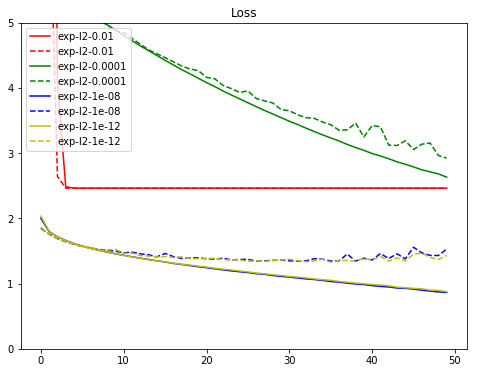

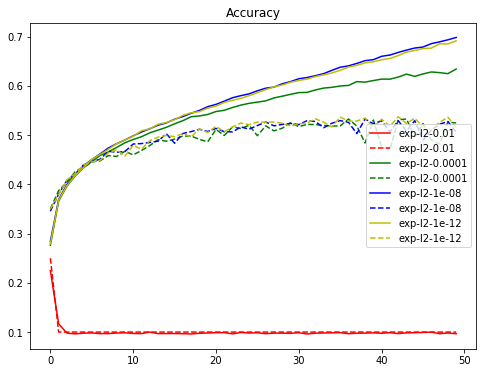

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y"]

results = results_L1
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
results_L2 = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_wL2(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results_L2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 151us/step - loss: 1.6159 - accuracy: 0.5227 - val_loss: 1.6852 - val_accuracy: 0.4877
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.6154 - accuracy: 0.5205 - val_loss: 1.7075 - val_accuracy: 0.4814
Epoch 50/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.6099 - accuracy: 0.5245 - val_loss: 1.6727 - val_accuracy: 0.4920
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.0744 - accuracy: 0.6746 - val_loss: 1.5454 - val_accuracy: 0.5254
Epoch 47/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.0605 - accuracy: 0.6764 - val_loss: 1.5267 - val_accuracy: 0.5287
Epoch 48/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.0486 - accuracy: 0.6827 - val_loss: 1.5675 - val_accuracy: 0.5172
Epoch 49/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.0334 - accuracy: 0.6871 - val_loss: 1.5085 - val_accuracy: 0.5319
Epoch 50/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.0263 - accuracy: 0.6877 - val_loss: 1.6880 - val_accuracy: 0.4954
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 8s 154us/step - loss: 0.9503 - accuracy: 0.6686 - val_loss: 1.3707 - val_accuracy: 0.5273
Epoch 44/50
50000/50000 [==============================] - 8s 157us/step - loss: 0.9328 - accuracy: 0.6753 - val_loss: 1.3774 - val_accuracy: 0.5310
Epoch 45/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.9241 - accuracy: 0.6785 - val_loss: 1.3966 - val_accuracy: 0.5227
Epoch 46/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.9055 - accuracy: 0.6860 - val_loss: 1.4011 - val_accuracy: 0.5274
Epoch 47/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.8985 - accuracy: 0.6873 - val_loss: 1.5972 - val_accuracy: 0.4844
Epoch 48/50
50000/50000 [==============================] - 8s 155us/step - loss: 0.8889 - accuracy: 0.6904 - val_loss: 1.4534 - val_accuracy: 0.5143
Epoch 49/50
50000/50000 [==============================] - 8s 155us/step - loss: 0.8751 - accuracy: 0.6961 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 8s 156us/step - loss: 0.9977 - accuracy: 0.6487 - val_loss: 1.4105 - val_accuracy: 0.5145
Epoch 42/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.9885 - accuracy: 0.6518 - val_loss: 1.4990 - val_accuracy: 0.4989
Epoch 43/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.9753 - accuracy: 0.6570 - val_loss: 1.4304 - val_accuracy: 0.5109
Epoch 44/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.9662 - accuracy: 0.6588 - val_loss: 1.3540 - val_accuracy: 0.5323
Epoch 45/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9532 - accuracy: 0.6657 - val_loss: 1.3705 - val_accuracy: 0.5239
Epoch 46/50
50000/50000 [==============================] - 8s 154us/step - loss: 0.9416 - accuracy: 0.6695 - val_loss: 1.4971 - val_accuracy: 0.5020
Epoch 47/50
50000/50000 [==============================] - 8s 158us/step - loss: 0.9326 - accuracy: 0.6704

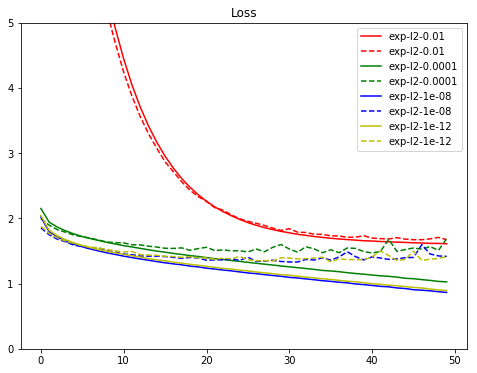

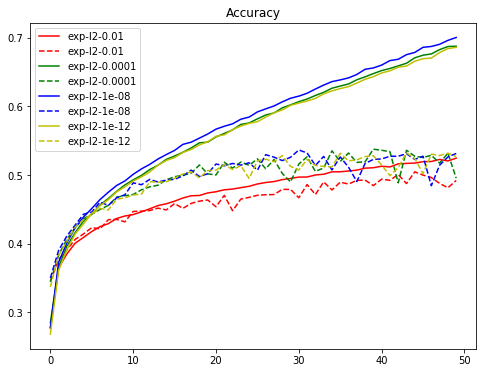

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y"]

results = results_L2
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
results_L1_L2 = {}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_wL1_L2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results_L1_L2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 9s 175us/step - loss: 2.4614 - accuracy: 0.0983 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 9s 184us/step - loss: 2.4614 - accuracy: 0.0977 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4614 - accuracy: 0.0962 - val_loss: 2.4615 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

50000/50000 [==============================] - 11s 216us/step - loss: 1.7701 - accuracy: 0.4775 - val_loss: 1.7897 - val_accuracy: 0.4662
Epoch 46/50
50000/50000 [==============================] - 10s 204us/step - loss: 1.7650 - accuracy: 0.4767 - val_loss: 1.7820 - val_accuracy: 0.4703
Epoch 47/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.7620 - accuracy: 0.4764 - val_loss: 1.7856 - val_accuracy: 0.4759
Epoch 48/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.7562 - accuracy: 0.4795 - val_loss: 1.7826 - val_accuracy: 0.4679
Epoch 49/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.7546 - accuracy: 0.4803 - val_loss: 1.8036 - val_accuracy: 0.4604
Epoch 50/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.7521 - accuracy: 0.4791 - val_loss: 1.7666 - val_accuracy: 0.4790
Experiment with Regulizer = 0.000000
Model: "model_1"
______________________________________________________________

50000/50000 [==============================] - 9s 185us/step - loss: 1.6426 - accuracy: 0.5166 - val_loss: 1.6890 - val_accuracy: 0.4952
Epoch 43/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.6357 - accuracy: 0.5172 - val_loss: 1.6890 - val_accuracy: 0.4947
Epoch 44/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.6310 - accuracy: 0.5194 - val_loss: 1.7310 - val_accuracy: 0.4824
Epoch 45/50
50000/50000 [==============================] - 9s 181us/step - loss: 1.6253 - accuracy: 0.5202 - val_loss: 1.6684 - val_accuracy: 0.5034
Epoch 46/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6225 - accuracy: 0.5214 - val_loss: 1.6844 - val_accuracy: 0.4990
Epoch 47/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.6189 - accuracy: 0.5233 - val_loss: 1.6620 - val_accuracy: 0.5080
Epoch 48/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.6144 - accuracy: 0.5231 - val_loss

50000/50000 [==============================] - 9s 177us/step - loss: 1.6647 - accuracy: 0.5118 - val_loss: 1.7445 - val_accuracy: 0.4783
Epoch 40/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.6572 - accuracy: 0.5121 - val_loss: 1.7435 - val_accuracy: 0.4783
Epoch 41/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6511 - accuracy: 0.5143 - val_loss: 1.6947 - val_accuracy: 0.4908
Epoch 42/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.6459 - accuracy: 0.5154 - val_loss: 1.7060 - val_accuracy: 0.4882
Epoch 43/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.6399 - accuracy: 0.5161 - val_loss: 1.6736 - val_accuracy: 0.5025
Epoch 44/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.6327 - accuracy: 0.5181 - val_loss: 1.7268 - val_accuracy: 0.4819
Epoch 45/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.6296 - accuracy: 0.5198 - val_los

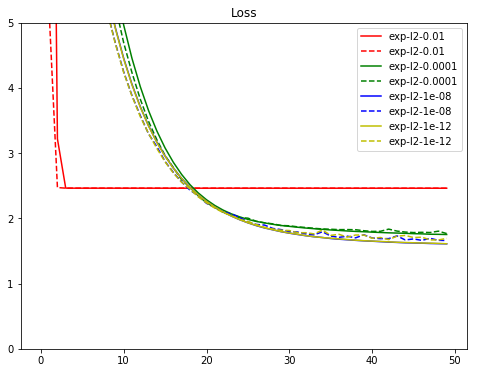

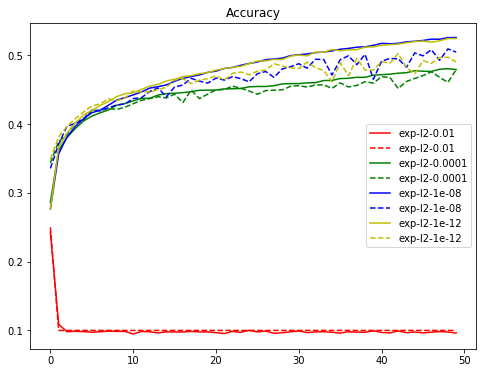

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y"]

results = results_L1_L2
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()